# Abstract

# Introduction

## Motivation

GPS based automobile routing applications such as Google Maps currently route drivers to their destinations as quickly as possible by minimizing the traffic, road-work/blockages, and user-reported obstacles/accidents (citation). Open-source routing projects such as OpenRouteService have taken more varied approaches to the routing problem for example, maximizing time spent on well-maintained roads (EXAMPLE Curviness routing). Currently, there are no publicly available routing applications that use road safety data to maximize driver safety.

Road safety data has historically been analyzed by state Departments of Transportation for the purpose of revising roads to improve public safety (citation). The usage of road safety data for the immediate routing changes of individual drivers compliments the department of transportation efforts in improving public safety. Small-scale adoption of safety-based routing would improve safety for users of the novel routing application, while road revisions would continue to improve total driver safety. Network effects of a large-scale automobile routing change have not been studied for the scope of this project and would be required future research before large-scale deployment of such a routing update.

## Data Availability

Data used for this project comes for the Pennsylvania Department of Transportation and the Carnegie Mellon Traffic 21 Institute. There are two primary datasets being utilized to evaluate the safety of the road network in Allgeheny County PA. The first dataset includes information regarding the description of crashes in Allgeheny County PA between (X-X). The second dataset consists of average hourly traffic counts at (X) sensor locations between the years (X-X) in the Allgeheny County area collected through a collaboration between the Carnegie Mellon Traffic 21 Institute and the Pennsylvania Department of Transportation.

The unique data sources utilized for this project provide advantages over commonly available Department of Transportation statistics for road safety. The descriptive automobile crash dataset includes recorded locations, given as latitude-longitude coordinates, for nearly all crashes in the dataset.  The high-degree of combined spatial-temporal specificity between the crash description and traffic dataset allows individual road segments to be closely analyzed without reductive assumptions required when utilizing aggregated data.

Datasets with similar spatial-temporal specificity are needed to employ the methods discussed in this project. Justification for the key features that enable ranking of individual roads in a road network are discussed further in (SECTION X).

Data was obtained from Data.gov which hosts several datasets from various parts of the U.S. Government. Both the traffic and crash description datasets were hosted at data.gov in comma-separated-value format. This type of data can easily be analyzed with built-in reading tools from the pandas python package. Accompanying data dictionaries were hosted in pdf format.

## Project Scope

This project carries out the process of introducing and evaluating a novel historical safety metric for the road network of Allgeheny County, PA. Statistical testing is used to evaluate the robustness of the safety metric for routing adjustment. Accompanying visualizations illustrate the variation of safety across the road network.

Applications of the metric to routing problems is not completed in this project. Scalability of the metric to larger road networks (statewide, nation, global) is not analyzed in this project. Guidelines and suggestions for future work extending this project are outlined in (SECTION X-FUTURE WORK?).

# Literature Review

# Methodology

## High-Level Methodology

![Analysis Steps](flowchart.png)

The flowchart above demonstrates the broad steps from the crash and traffic datasets to a metric and analysis of road network danger. Initially, the datasets must be manipulated to deal with missing values, identify useful columns, and apply transformations to allow for analysis in later stages of the pipeline. After both the crash and traffic datasets have been cleaned the process of normalization combines the two datasets by pairing each crash with the most relevant traffic data.

The normalization process is described extensively in XXXX, but the reason for normalization can be understood intuitively by considering the relative danger between a well-maintained, busy city-road and an ill-maintained rural road. A non-normalized approach to this analysis will likely rank the rural road as 'safer' because less accidents are likely to have occured on a rural road, but this is likely due to the fact that there are simply less cars on that road. The risk of getting in a crash can be expressed by the number of crashes over the number of total cars or traffic on a road. The fallacy of analyzing only crash data is equating number of crashes with road danger, when in reality danger is a function of both crashes and traffic.

After the datasets have been combined, road danger must be defined by the quantities available in the combined dataset. The starting point for analyzing road danger is the normalized expression for risk described in the previous paragraph. However, risk alone does not capture the danger of a road. This can be explained by another hypothetical option between a congested 35 mph city-zone or a high-speed highway. The crash risk may very well be lower for the highway as a function of its high traffic which drives down risk. However, not all crashes are equivalent and it is almost a certainty that the severity of crashes on the high-speed highway are higher than the relatively low-speed city road. Therefore, it would be a mistake to conclude the highway is safer than the city-road based on crash risk alone because risk fails to capture severity. The metric presented in XXXXX uses severity and risk to construct a measurement for danger.

With a road danger metric established it may appear tempting to immediately conclude all roads with worse scores are more dangerous, but this ignores the  role of random variation. Is a small high-traffic road with a single crash less dangerous than an equivalently sized road with two crashes? These questions can be answered with statistical significance testing. Routing alterations should only be made when the effect size, and the statisical significance of the supposedly 'safer' route have been considered. The concepts of signficance and effect size also extend to analyzing which conditions increase or decrease safety such as light levels, weather, and traffic signal types. Applications of the road danger metric to answering questions of routing and conditions can be found in section XXXXXXX.

## Tools Used

All data analysis for this project was performed using Python 3.6 along with packages that extend the base functionality of Python. This thesis was written entirely in Jupyter Notebooks, an open-source web application that allows for coding, markdown text, and visualizations to all be embedded in a single document. Packages used in this thesis are listed in the imports below. Note that '%' indicates a magic word in Jupyter notebooks and '%matplotlib inline' configures the document to render images inside the notebook instead of another window.

Pandas and datetime are used for data manipulation, cleaning, and transformation. Numpy extends the numerical computing options of Python and provides the missing value type NaN, as well as various array types and methods. Matplotlib, and seaborn are used for plotting and visualizations. Scipy.stats is used for statistical testing.

In [131]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import scipy.stats as stats
from scipy.spatial import KDTree
import powerlaw as pl

## Importing the Data

Both traffic and crash description datasets are available in .csv format from the Data.gov portal. Importing .csv data into python is accomplished using the built-in .read_csv function from the pandas package.

   The pandas packages converts .csv files to dataframe structures which can be conceptualized as augmented spreadsheets. Like spreadsheets, dataframes can be manipulated with common aggregation, groupby, merging, and indexing operations using built-in pandas methods.

In [2]:
crash = pd.read_csv('crashdata.csv')
crash.head()

c:\users\ari\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (79,183) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CRASH_CRN,DISTRICT,CRASH_COUNTY,MUNICIPALITY,POLICE_AGCY,CRASH_YEAR,CRASH_MONTH,DAY_OF_WEEK,TIME_OF_DAY,HOUR_OF_DAY,...,ACCESS_CTRL,ROADWAY_COUNTY,LANE_COUNT,RDWY_ORIENT,ROAD_OWNER,ROUTE,SPEED_LIMIT,SEGMENT,OFFSET,STREET_NAME
0,2.004000e+09,11.0,2.0,2454.0,02454,2004.0,1.0,5.0,257.0,2.0,...,3.0,2.0,2.0,E,2.0,2032,35.0,10.0,1000.0,LEWIS RUN RD
1,2.004000e+09,11.0,2.0,2440.0,02440,2004.0,1.0,5.0,1027.0,10.0,...,NaN,2.0,2.0,W,3.0,NaN,35.0,NaN,NaN,COAL VALLEY RD
2,2.004000e+09,11.0,2.0,2203.0,02203,2004.0,1.0,5.0,1839.0,18.0,...,NaN,2.0,2.0,W,2.0,3082,35.0,NaN,NaN,CLINTON FRANKFORT RD
3,2.004000e+09,11.0,2.0,2404.0,02404,2004.0,1.0,6.0,914.0,9.0,...,NaN,2.0,2.0,N,4.0,NaN,25.0,NaN,NaN,NORTH BALPH AV
4,2.004000e+09,11.0,2.0,2419.0,02419,2004.0,1.0,5.0,2230.0,22.0,...,NaN,2.0,2.0,S,4.0,NaN,20.0,NaN,NaN,THORNBERRY DR


In [3]:
traffic = pd.read_csv('data-trafficcounts.csv')
traffic.head()

,sensor_ID,Longitude,Latitude,1a,2a,3a,4a,5a,6a,7a,...,3p,4p,5p,6p,7p,8p,9p,10p,11p,12a
0,5879@1,-79.861523,40.625398,44.0,19.0,14.0,18.0,36.0,151.0,362.0,...,481.0,604.0,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0
1,5970@1,-79.796409,40.445047,18.0,19.0,24.0,31.0,100.0,223.0,356.0,...,463.0,561.0,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0
2,5957@1,-79.820976,40.487624,60.0,36.0,39.0,27.0,45.0,165.0,395.0,...,532.0,637.0,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0
3,120@1,-79.703859,40.443548,27.0,7.0,14.0,9.0,35.0,119.0,365.0,...,508.0,640.0,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0
4,26732@1,-80.114273,40.389899,19.0,14.0,7.0,10.0,9.0,33.0,113.0,...,195.0,247.0,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0


Before insights can be obtained from the crash and traffic dataframes there are a series of data cleaning steps. The first step is to slice dataframes to relevant columns. After the dataframes have been reduced to only relevant fields, missing values must be addressed. The approach to missing values is dependent on usage and each approach will be appropriately justified.

After both datasets have been cleaned, normalization occurs by combining the crash and traffic datasets. The effectiveness of normalization can be visualized by comparing pre-normalized crash frequency data by hour to normalized data. After a clean, combined, and normalized dataset is obtained in the form of a dataframe statistical analyses and more robust visualizations can be created.

## Obtaining relevant columns


Descriptions of all columns are listed in the official crash data dictionary (Appendix 1). For the scope of this project relevant columns can be split into four general categories: date-time, conditions, severity, and location. Each of these categories requires specific considerations of missing values, and formatting for ease-of-use in analysis stage of the project.

### Date-time attributes


The time of each crash occurence becomes important in the normalization step where an appropriate traffic value is paired with each crash. Traffic is recorded hourly, and matching the hour the crash occured with the hour the traffic was recorded allows for more accurate normalization. While the traffic dataset only includes hour of sensor reading the crash dataset has more expansive date-time features and includes year, month, hour, time, and day-of-week. Datetime features can be combined in pandas into a single column which can then be accessed by .dt pandas methods.

Converting the year, month, hour, time, and day-of-week to a single column expressing datetime requires some manipulation. The first issue is hour and time contain overlapping information because time is expressed as a string represting 24-hour time for example '2345.' The time column can be manipulated by converting to integer-type and taking the remainder after dividing by 100 which leaves only the first two digits. For example '2345' becomes the integer 2345 and then taking 2345 mod 100 yields 45, the minute at which the crash occured. This conversion is applied to all values in the time column to transform the column to represent minutes.

The remaining issue before converting into a singular datetime column, is the lack of week information. Because day is only recorded in the dataset as day-of-week there is no way to determine the week of the month in which a crash occured. The day-of-week column is provided to the datetime conversion method as day, but the limitation of differentiating between weeks remains.

Missing values in the datetime features are recorded as 9999 and are replaced by numpy NaN which is recognized as a missing value by pandas. The pandas .dropna() method is used to remove any rows with missing datetime information which reduces the useable rows from 157821 to 154343. Crashes without datetime information form a small part of the total dataset (~2%) and cannot be matched with a traffic sensor reading from the same hour. Additionally, crashes with missing datetime information cannot be converted into a single datetime column. An alternative approach to handling missing values in the datetime columns would be to only eliminate entries with missing hourly data and record NaN in the single datetime column but retain the hour column for matching with sensors. The decision to drop missing values was informed by the low ratio of missing data to complete data in the datetime features.

In [4]:
# Creating dataframe of just time attributes
crash_time = crash.loc[:,['CRASH_YEAR', 'CRASH_MONTH', 'HOUR_OF_DAY', 'TIME_OF_DAY', 'DAY_OF_WEEK']]
# Limitation of data is day of week is recorded but not day
crash_time.DAY_OF_WEEK.max()
crash_time.columns = ['year', 'month', 'hour', 'time', 'day']

In [5]:
crash_time.shape

(157821, 5)

In [6]:
# Replacing NaN
crash_time.replace(9999,np.NaN, inplace = True)

In [7]:
# Converting to int for datetime
crash_time.dropna(inplace = True)

In [8]:
crash_time.astype(int).head()

,year,month,hour,time,day
0,2004,1,2,257,5
1,2004,1,10,1027,5
2,2004,1,18,1839,5
3,2004,1,9,914,6
4,2004,1,22,2230,5


In [10]:
# Creating minute column from last 2 digits of time
crash_time['minute'] = crash_time.time % 100
crash_time.head()

,year,month,hour,time,day,minute
0,2004.0,1.0,2.0,257.0,5.0,57.0
1,2004.0,1.0,10.0,1027.0,5.0,27.0
2,2004.0,1.0,18.0,1839.0,5.0,39.0
3,2004.0,1.0,9.0,914.0,6.0,14.0
4,2004.0,1.0,22.0,2230.0,5.0,30.0


In [11]:
# Note that the day will only be between 1 and 7 because no exact day information is available
crash_datetime = pd.to_datetime(crash_time[['year', 'month', 'day', 'hour', 'minute']])

Figure XXXX shows the capabilities of the .dt methods within pandas. The 'month' keyword isolates month for each crash, which is easily plotted using the value_counts method to sum all crashes for each month. The sort_index method orders the months in ascending order, and the .plot pandas method calls the matplotlib api to output a graph of the kind specified within the .plot argument.

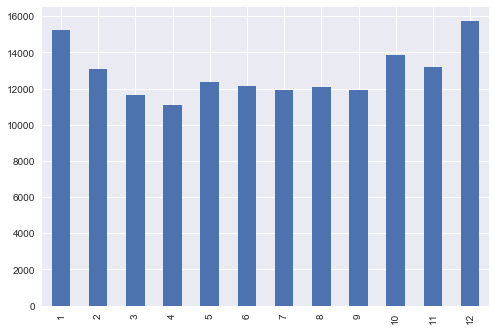

In [12]:
crash_datetime.dt.month.value_counts().sort_index().plot(kind = 'bar')

The following Figures XXXXXXX, XXXXX, XXXX use a similar method described above to plot the number of crashes each year, day-of-the-week, and week.

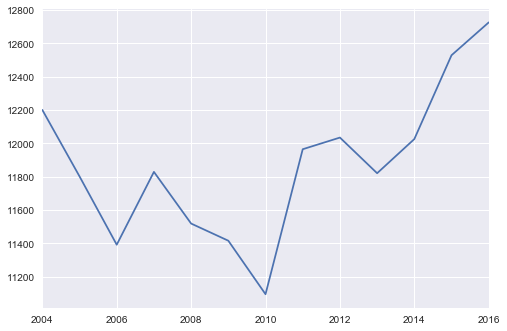

In [13]:
crash_datetime.dt.year.value_counts().sort_index().plot()

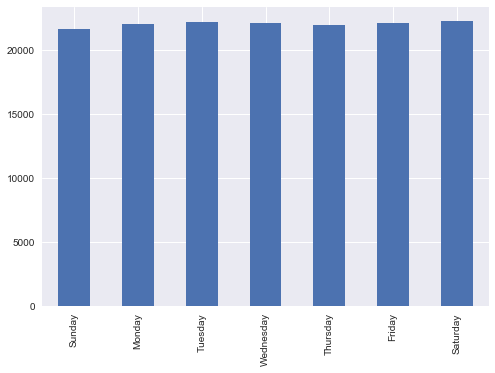

In [14]:
dayofweek = crash_datetime.dt.dayofweek.value_counts().sort_index()
dayofweek.index = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
dayofweek.plot(kind = 'bar')

The number of crashes by week plot appears inconsistent because day-of-week was used in place of day during the conversion to a single datetime column. Therefore, there are weeks which appear to not have crashes simply because all crashes during the month will appear during the first couple weeks due to approximating day as day-of-week.

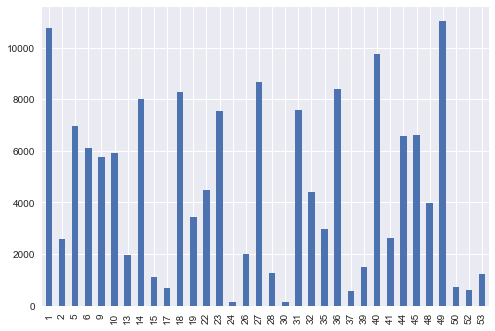

In [15]:
# Weekly graph looks odd because using day of week as day in datetime format eliminates all week 3/4 data for any month
crash_datetime.dt.week.value_counts().sort_index().plot(kind = 'bar')

### Condition attributes

The crash dataset contains several fields related to the conditions under which a crash took place. After a metric for measuring danger is established it becomes possible to approach questions such as: 'Is it more dangerous to drive in the rain or fog?' For this reason external conditions pertaining to the crash are extracted from the main crash dataframe. The following conditions are of interest for this project: weather, illumination, intersection type, location type (bridge/underpass/etc), relation to road (on road/median/etc), road condition (dry/wet/etc), speed limit, traffic control type (stop sign/traffic signal/etc).

By default, the conditions described above are stored as numerical float values which requires looking up corresponding descriptions in the official crash data dictionary. In order to eliminate this step, dictionaries can be created for each condition and the .applymap pandas method can be used to create descriptive columns in addition to the default numerical columns for conditions.

Handling of missing values and analysis of conditions is completed after establishment of the danger metric, which does not depend on any of the condition attributes in the dataset. After the danger metric is established the condition attributes can be merged onto the resulting dataframe and statistical analysis of conditions can be performed. This occurs in section XXXXX.

In [16]:
crash_conditions = crash.loc[:, ('WEATHER', 'ILLUMINATION', 'INTERSECT_TYPE', 'LOCATION_TYPE', 'RELATION_TO_ROAD', 'ROAD_CONDITION', 'SPEED_LIMIT', 'TCD_TYPE')]
crash_conditions.head()

,WEATHER,ILLUMINATION,INTERSECT_TYPE,LOCATION_TYPE,RELATION_TO_ROAD,ROAD_CONDITION,SPEED_LIMIT,TCD_TYPE
0,1.0,2.0,0.0,0.0,2.0,0.0,35.0,0.0
1,1.0,1.0,0.0,0.0,5.0,6.0,35.0,0.0
2,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0
3,1.0,1.0,1.0,0.0,1.0,1.0,25.0,2.0
4,1.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0


In [17]:
weather_di = {1:'No adverse conditions',
              2: 'Rain',
              3: 'Sleet (hail)',
              4: 'Snow',
              5: 'Fog',
              6: 'Rain and fog',
              7: 'Sleet and fog',
              8: 'Other',
              9: np.NaN}
illumination_di = {1: 'Daylight',
                   2: 'Dark - no street lights',
                   3: 'Dark - street lights',
                   4: 'Dusk',
                   5: 'Dawn',
                   6: 'Dark - unknown roadway lighting',
                   8: 'Other',
                   9: np.NaN}
intersect_di = {0: 'Mid-block',
                1: 'Four way intersection',
                2: 'T intersection',
                3: 'Y intersection',
                4: 'Traffic circle/Round about',
                5: 'Multi-leg intersection',
                6: 'On ramp',
                7: 'Off ramp',
                8: 'Crossover',
                9: 'Railroad crossing',
                10: 'Other',
                99: np.NaN}
location_di = {0: 'Not applicable',
               1: 'Underpass',
               2: 'Ramp',
               3: 'Bridge',
               4: 'Tunnel',
               5: 'Toll Booth',
               6: 'Cross over related',
               7: 'Driveway or Parking Lot',
               8: 'Ramp and bridge',
               9: np.NaN}
relation_di = {1: 'On roadway',
               2: 'Shoulder',
               3: 'Median',
               4: 'Roadside',
               5: 'Outside trafficway',
               6: 'In parking lane',
               7: 'Gore',
               9: np.NaN}
# Gore is intersection of ramp and highway
road_cond = {0: 'Dry',
             1: 'Wet',
             2: 'Sand/mud/dirt/oil/gravel',
             3: 'Snow covered',
             4: 'Slush',
             5: 'Ice', 
             6: 'Ice Patches',
             7: 'Water - standing/moving',
             8: 'Other',
             9: np.NaN}
tcdtype_di = {0: np.NaN,
              1: 'Flashing traffic signal',
              2: 'Traffic signal',
              3: 'Stop sign',
              4: 'Yield sign',
              5: 'Active RR crossing controls',
              6: 'Passive RR crossing controls',
              7: 'Police officer or flagman',
              8: 'Other type TCD'}

### Severity attributes

The severity attributes of the crash dataset are crucial for the creation of the danger metric because danger expresses risk and consequence, where the consequence in the case of a car crash is severity of the crash. The attributes related to severity in the crash dataset can be separated into discrete or continuous data. The discrete measures of severity within the dataset are fatal, fatal or major injury, injury, and major injury. For discrete variables if the condition is present the value is 1 and 0 if not present. The continuous measures of severity within the dataset are fatality count, injury count, major injury count, max severity level, and vehicle count.

The severity attribute with the highest resolution is the max severity level, and the data dictionary provides the appropriate lookups for the numerical values listed in the column which encode degree of injury from minor to killed. Unfortunately, missing values and injuries of unknown severity account for 20% of the total values listed in the max severity level column limiting usability. For the purposes of this project the severity attributes chosen do no include max severity level due to the noted limiatations. Usage of severity attributes is discussed in section XXXXX when the severity attributes are incorporated into the danger metric.

In [18]:
crash_severity = crash.loc[:,('FATAL', 'FATAL_COUNT', 'FATAL_OR_MAJ_INJ', 'INJURY', 'INJURY_COUNT', 'MAJ_INJ_COUNT', 'MAJOR_INJURY', 'MAX_SEVERITY_LEVEL', 'VEHICLE_COUNT')]

In [19]:
# Definitions from Data Dictionary
severity_di = {0:'Not injured',
              1: 'Killed',
            2: 'Major Injury',
               3: 'Moderate Injury',
               4: 'Minor Injury',
               8: 'Injury/Unknown Severity',
               9: np.NaN}
crash_severity.MAX_SEVERITY_LEVEL = crash_severity.MAX_SEVERITY_LEVEL.map(severity_di)

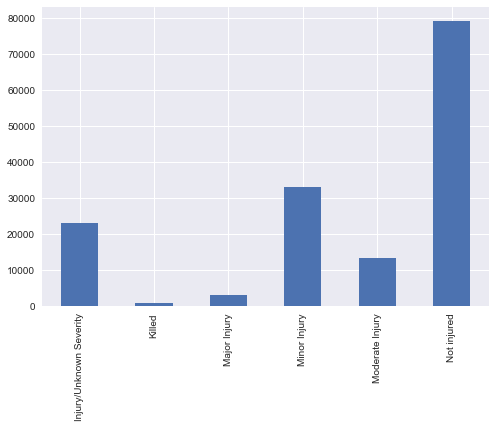

In [20]:
crash_severity.MAX_SEVERITY_LEVEL.value_counts().sort_index().plot(kind = 'bar')

In [21]:
crash_severity[(crash_severity.MAX_SEVERITY_LEVEL.isnull()) | (crash_severity.MAX_SEVERITY_LEVEL == 'Injury/Unknown Severity')].shape[0]

28546

In [22]:
crash_severity.shape[0]

157821

### Location attributes

The relevant location attributes included in the crash dataset include latitude, longitude, and street name. Latitude and longitude act as merge keys throughout the project. Grouping the dataset by street name allows roads to be compared for crash frequency, risk, and danger using groupby methods without requiring additional GIS data sources that map latitude and longitude to a street.

Missing values in the location attributes columns are dropped. Both latitude and longitude are necessary for normalization, street name is required to answer the central question 'which route and thus which roads are more dangerous?' With additional GIS data it would be possible to fill missing values by looking up coordinates or street names and assigning the appropriate value to the missing column. Possibilities for using additional GIS data are further discussed in XXXXX (future work). 

In [23]:
# Dataframe of crash locations and street names
crash_location = crash.loc[:,['DEC_LAT', 'DEC_LONG', 'STREET_NAME']]
crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME
0,40.3234,-79.9404,LEWIS RUN RD
1,40.3182,-79.9076,COAL VALLEY RD
2,40.4886,-80.3371,CLINTON FRANKFORT RD
3,NaN,NaN,NORTH BALPH AV
4,NaN,NaN,THORNBERRY DR


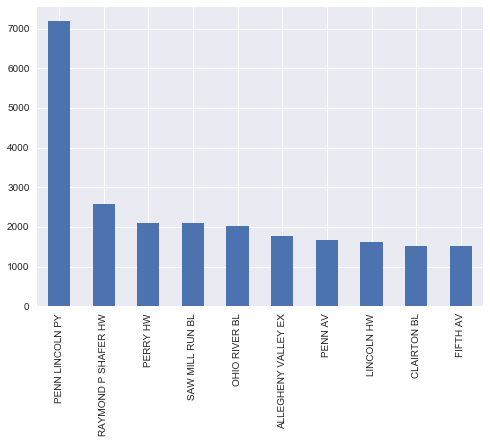

In [24]:
# 10 most dangerous roads (Most are highways)
crash_location.STREET_NAME.value_counts().head(10).plot(kind = 'bar')

## Motivation for Normalization

The need for normalization is based off the intuition that traffic and crashes are positively correlated. This can be demonstrated using the crash and traffic datasets to confirm this correlation exists.

Unlike the crash dataset, the traffic dataset does not contain superfluous columns. Location of each sensor is recorded in latitude, longitude form and average traffic counts are recorded for each hour at each sensor. The average is taken over the period of traffic data collection (2012-2014). Missing values are recorded as an entry of -1, and are replaced by the NaN datatype using pandas and numpy. Handling of missing values is discussed further in section XXXX.

Plotting average hourly traffic at a sensor (figure XXXX) indicates traffic spikes during rush hours as expected and drops during night hours. 

In [25]:
# Traffic by hour
t_hour = traffic.iloc[:,3:]

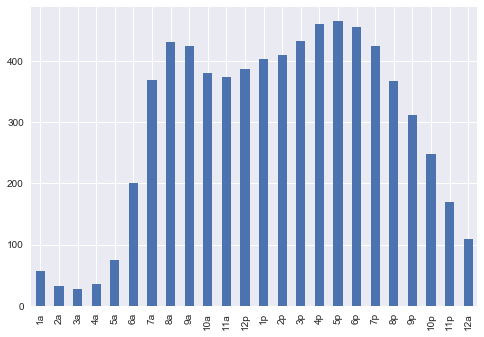

In [50]:
# Dropping NaN and visualizng total average traffic at all sensors each hour
t_hour.replace(-1,np.nan, inplace=True)
t_hour.dropna().mean().plot(kind = 'bar')

Similarily, plotting total crashes per hour reveals peaks at the rush hours. Interestingly, the crashes peak more acutely in the afternoon rush hour. The general observation is the pattern in traffic counts and crash counts appear similar. This similarity can be numerically quantified using correlation.

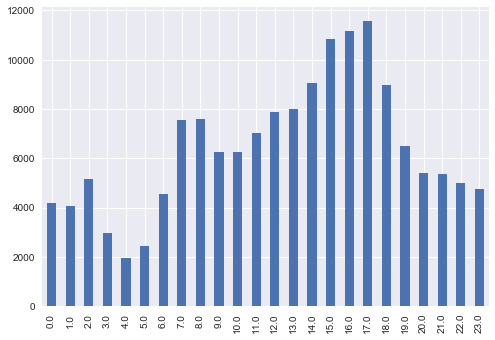

In [27]:
# Visualizing total crashes each hour
crash['HOUR_OF_DAY'].replace(99, np.nan, inplace = True)
c_hour = crash['HOUR_OF_DAY'].value_counts().sort_index()
c_hour.plot(kind = 'bar')

In [28]:
# Building series of average traffic with 0-23 hour labels
avg_t = t_hour.mean()
c_hour = c_hour.astype(float)
avg_t.reset_index(drop = True, inplace = True)
avg_t.index = (avg_t.index + 1) % 24

In [29]:
# Building dataframe of total crashes, and average traffic each hour
c_sum_t_avg = pd.concat([c_hour, avg_t], axis = 1)
c_sum_t_avg.columns = ['Total Crashes', 'Average traffic']
c_sum_t_avg.head()

,Total Crashes,Average traffic
0.0,4179.0,101.616356
1.0,4082.0,53.796416
2.0,5157.0,31.218393
3.0,2961.0,27.397583
4.0,1968.0,34.771707


The correlation between total crashes each hour and average traffic at a sensor each hour can be visualized in the following scatter plots. Figure XXXX shows the data without any regression line while Figure XXXX shows the data with a regression line and correlation coefficient. The scatter plots confirm there is a strong positive correlation between the two variables and provides evidence that normalization is necessary to avoid mistaking a measurement of road traffic as a measurement of road danger.

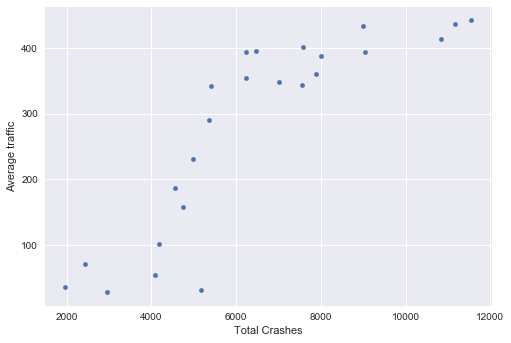

In [30]:
c_sum_t_avg.plot.scatter(x = 'Total Crashes', y = 'Average traffic')

0.85413233460318705

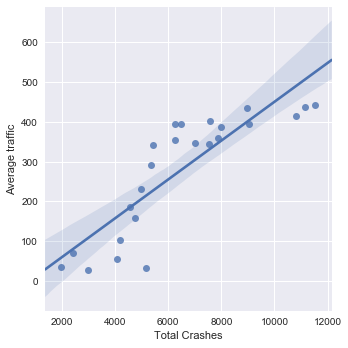

In [31]:
sns.lmplot('Total Crashes', 'Average traffic', data = c_sum_t_avg)
stats.pearsonr(c_sum_t_avg['Total Crashes'], c_sum_t_avg['Average traffic'])[0]

## Normalization

Preparation of the crash dataset for normalization begins with isolating the fields required for merging with traffic data. Only datetime, and location data attributes are required from the crash dataset to match each crash with the appropriate traffic value. Condition and severity attributes will be merged onto the dataset for analysis using latitude and longitude as merge keys further in the project.

Combination of the datetime features into a single column is performed as described in section XXXX above effectively reducing the size of the dataframe. Any row with a missing value is dropped as datetime and location are necessary to determine a matching traffic value.

In [32]:
crash_location = crash.loc[:,('CRASH_YEAR', 'CRASH_MONTH', 'HOUR_OF_DAY', 'TIME_OF_DAY',
                              'DAY_OF_WEEK','DEC_LAT', 'DEC_LONG', 'STREET_NAME')]
# Limitation of data is day of week is recorded but not day
crash_location.dropna(inplace = True)

crash_location.rename(columns={'CRASH_YEAR':'year',
                               'CRASH_MONTH':'month',
                               'HOUR_OF_DAY':'hour',
                               'TIME_OF_DAY':'time',
                               'DAY_OF_WEEK':'day'}, inplace = True)
crash_location['minute'] = crash_location.time % 100
crash_location['datetime'] = pd.to_datetime(crash_location[['year', 'month', 'day', 'hour', 'minute']])
crash_location.drop(['year', 'month', 'hour', 'time','day','minute'],axis = 1,inplace = True)
crash_location.reset_index(drop = True, inplace = True)

crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME,datetime
0,40.3234,-79.9404,LEWIS RUN RD,2004-01-05 02:57:00
1,40.3182,-79.9076,COAL VALLEY RD,2004-01-05 10:27:00
2,40.4886,-80.3371,CLINTON FRANKFORT RD,2004-01-05 18:39:00
3,40.4188,-80.0494,POPLAR ST,2004-01-06 14:30:00
4,40.4612,-80.0087,PERRYSVILLE AV,2004-01-01 19:20:00


The traffic dataset is manipulated through renaming and rearrangement of columns. The raw traffic dataset gives column names as strings in 12-hour time format. The columns are renamed to integers on a 24-hour time scale. The datetime format of the crash dataset uses a 0-23 hour format. The 24-hour case is handled during matching of traffic values rather than in pre-processing of the data.

In [33]:
# Replacing null values
traffic.replace(-1,np.NaN,inplace = True)

In [34]:
# Reordering the traffic dataframe to match the latitude longitude form of the crash dataframe
traffic_cols = traffic.columns.tolist()
traffic_cols = traffic_cols[1:] + [traffic_cols[0]]
traffic_cols[0] = 'Latitude'
traffic_cols[1] = 'Longitude'
traffic = traffic[traffic_cols]
traffic.head()

,Latitude,Longitude,1a,2a,3a,4a,5a,6a,7a,8a,...,4p,5p,6p,7p,8p,9p,10p,11p,12a,sensor_ID
0,40.625398,-79.861523,44.0,19.0,14.0,18.0,36.0,151.0,362.0,606.0,...,604.0,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0,5879@1
1,40.445047,-79.796409,18.0,19.0,24.0,31.0,100.0,223.0,356.0,385.0,...,561.0,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0,5970@1
2,40.487624,-79.820976,60.0,36.0,39.0,27.0,45.0,165.0,395.0,584.0,...,637.0,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0,5957@1
3,40.443548,-79.703859,27.0,7.0,14.0,9.0,35.0,119.0,365.0,550.0,...,640.0,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0,120@1
4,40.389899,-80.114273,19.0,14.0,7.0,10.0,9.0,33.0,113.0,232.0,...,247.0,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0,26732@1


In [35]:
# Rename columns in traffic
# Must rename columns of traffic to match 0-23 hour system
traffic_cols = traffic.columns.tolist()
traffic_cols[2:-1] = list(range(1,25))
print(len(traffic_cols))
# Not easy way to perform modulus here afaik so handle the 0/24 case in function
traffic.columns = traffic_cols
traffic.head(),traffic.loc[:,5].head()

27


(    Latitude  Longitude     1     2     3     4      5      6      7      8  \
 0  40.625398 -79.861523  44.0  19.0  14.0  18.0   36.0  151.0  362.0  606.0   
 1  40.445047 -79.796409  18.0  19.0  24.0  31.0  100.0  223.0  356.0  385.0   
 2  40.487624 -79.820976  60.0  36.0  39.0  27.0   45.0  165.0  395.0  584.0   
 3  40.443548 -79.703859  27.0   7.0  14.0   9.0   35.0  119.0  365.0  550.0   
 4  40.389899 -80.114273  19.0  14.0   7.0  10.0    9.0   33.0  113.0  232.0   
 
      ...         16     17     18     19     20     21     22     23     24  \
 0    ...      604.0  678.0  790.0  575.0  431.0  416.0  227.0  188.0  119.0   
 1    ...      561.0  535.0  402.0  315.0  258.0  200.0  119.0   78.0   36.0   
 2    ...      637.0  662.0  715.0  611.0  511.0  429.0  247.0  170.0  106.0   
 3    ...      640.0  698.0  731.0  471.0  390.0  278.0  146.0  111.0   56.0   
 4    ...      247.0  309.0  348.0  324.0  264.0  181.0  140.0   87.0   54.0   
 
    sensor_ID  
 0     5879@1  
 1  

There are several approaches to finding the closest sensor to each crash. The crash dataset containing locations and datetime information is over 100K rows which makes naive methods that iterate through the entire traffic array for each crash non-desirable. Additionaly, a naive method is not scalable to larger implementations of normalization between crash and traffic datasets. Fortunately, the scipy.spatial.KDTree class provides a binary tree based approach to nearest-neighbor lookup widely appropriate for low-dimensional problems. A k-d tree is constructed of all sensor locations and then queried for each crash occurence to find the closest sensor.

Traditionally, the approach to finding distance between latitude longitude coordinates is accomplished using the Haversine formula which approximates the Earth as a sphere. This method is incompatible with KDTree methods of nearest neighbor lookup because the Haversine formula calculates Orthodromic distances, distance measure between points in a sphere, and is incompatible with the construction of the k-d tree.

The approach used in this project is to convert latitude longitude coordinates in both the crash and traffic datasets into the earth-centered, earth-fixed cartesian format system and then use the euclidean distance metric to find closest neighbors in the k-d tree. The WGS84 ellipsoid model is used for conversion to earth-centered, earth-fixed coordinates which has an estimated error of less than 2 centimeters and is the standard ellipsoid earth model for GPS systems. (CITE XXXX)

![Earth-Centered, Earth-Fixed](ECEF.svg)

In [37]:
def LLHtoECEF(df):
    #df here is actually type series, named df becaue function applied to df
    # see http://www.mathworks.de/help/toolbox/aeroblks/llatoecefposition.html
    
    df.iloc[0] = np.deg2rad(df.iloc[0])         # Convert to radians
    df.iloc[1] = np.deg2rad(df.iloc[1])
    
    rad = np.float64(6378137.0)        # Radius of the Earth (in meters)
    f = np.float64(1.0/298.257223563)  # Flattening factor WGS84 Model
    
    cosLat = np.cos(df.iloc[0]) # Latitude is stored in first column
    sinLat = np.sin(df.iloc[0])
    FF     = (1.0-f)**2
    C      = 1/np.sqrt(cosLat**2 + FF * sinLat**2)
    S      = C * FF

    x = (rad * C)*cosLat * np.cos(df.iloc[1]) # Longitude stored in second column
    y = (rad * C)*cosLat * np.sin(df.iloc[1]) 
    z = (rad * S)*sinLat
    

    return (x ,y , z) # Returns tuple of ECEF in meters

In [38]:
traffic['ecef'] = traffic.apply(LLHtoECEF, axis = 1)

In [39]:
# For an unknown reason I need to use iloc to isolate the crash location columns before applying, likely due to datetime
crash_location['ecef'] = crash_location.iloc[:,:2].apply(LLHtoECEF, axis=1)

In [40]:
# Tuples must be split before constructing and querying tree
traffic_split = traffic.ecef.apply(pd.Series)
crash_split = crash_location.ecef.apply(pd.Series)
traffic_split.head(), crash_split.head()

(               0             1             2
 0  853344.192815 -4.772083e+06  4.130939e+06
 1  861072.600669 -4.783920e+06  4.115718e+06
 2  858479.025047 -4.781269e+06  4.119315e+06
 3  868818.276230 -4.782629e+06  4.115591e+06
 4  835201.086995 -4.792535e+06  4.111056e+06,
                0             1             2
 0  850576.077991 -4.794686e+06  4.105429e+06
 1  853386.215354 -4.794566e+06  4.104988e+06
 2  815363.016972 -4.788738e+06  4.119397e+06
 3  840267.393275 -4.789537e+06  4.113499e+06
 4  843139.559476 -4.785931e+06  4.117083e+06)

In [41]:
# Create KDTree for quick-queries to find nearest sensors
tree = KDTree(traffic_split, leafsize = 2)

In [42]:
# A query returns distance (in meters) and index of sensor which can be used to lookup sensor information in traffic dataframe
tree.query(crash_split.iloc[1,:])

(409.13786848945063, 1090)

Querying the k-d tree returns distance in meters between the crash location and the closest sensor and the index of the closest sensor. The distance in meters between the closest sensor found and each crash provides a metric for comparing different normalization technicques but was not explored further in this project. In the more common case of sparse traffic data it is worth exploring alternative normalization approaches incorporating distance (weighted average, fixed radius average, etc.).

The sensor index and the hour of the crash are used to find the traffic value at the closest sensor during the hour in which the crash occured. When there is a missing value for the traffic at the hour the crash occured the mean of the sensors readings is used.

In [43]:
# Series of tuples with 0 index corresponding with distance (m) and 1 index sensor index
distance_index = crash_split.apply(tree.query, axis = 1)

lookup_df = distance_index.apply(pd.Series)
lookup_df.columns = ['distance_m','sensor_index']

In [44]:
closest_sensor_indices = lookup_df.sensor_index.astype(int)

In [45]:
# Find the correct traffic for the time of day at which the crash occured
def traffic_hour(row):
    # print(row)
    column = row.datetime.hour
    # 0 corresponds with 24 in traffic dataframe
    if column == 0:
        column = 24
    df = traffic.iloc[closest_sensor_indices[row.name],:]
    # print(df), print(type(df))
    if np.isnan(df.loc[column]):
        return df.iloc[2:-2].mean()
    else:
        return df.loc[column]

In [46]:
crash_location['traffic'] = crash_location.apply(traffic_hour, axis = 1)
crash_location['sensor_distance'] = lookup_df.distance_m
crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,traffic,sensor_distance
0,40.3234,-79.9404,LEWIS RUN RD,2004-01-05 02:57:00,"(850576.077991, -4794686.27611, 4105428.63702)",25.0,252.784803
1,40.3182,-79.9076,COAL VALLEY RD,2004-01-05 10:27:00,"(853386.215354, -4794566.40574, 4104988.39864)",47.0,409.137868
2,40.4886,-80.3371,CLINTON FRANKFORT RD,2004-01-05 18:39:00,"(815363.016972, -4788738.45089, 4119397.20706)",19.0,2335.682864
3,40.4188,-80.0494,POPLAR ST,2004-01-06 14:30:00,"(840267.393275, -4789537.24936, 4113499.3667)",715.0,621.172308
4,40.4612,-80.0087,PERRYSVILLE AV,2004-01-01 19:20:00,"(843139.559476, -4785931.47629, 4117082.73095)",170.0,501.268419


After merging the appropriate traffic values onto the crash dataset normalization can be performed by dividing each crash by the corresponding traffic count. There is one caveat to this operation, traffic is recorded as an average hourly count and must be multiplied by the total number of days in the dataset (4,728) to convert to total hourly count. While this does not change the effect of normalization, using total hourly count allows - total crashes / total traffic count - to be interpreted as the risk of getting in a crash.

Plotting crash risk (as defined above) over each hour on the normalized data shows a fairly even risk profile during the day, from 7:00AM to 10:00PM and increased risk during night peaking at 3:00AM. From the bar plot (figure XXX) it is already clear that there is not a strong positive correlation between crash risk and traffic as the rush hour periods do not correspond with peaks in crash risk.

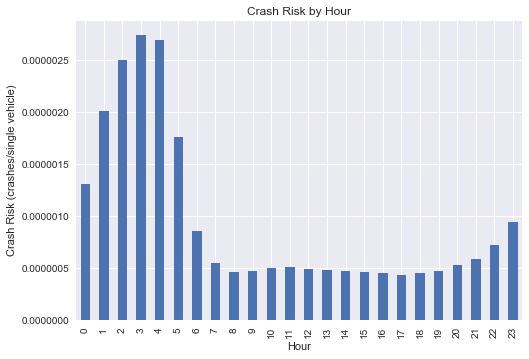

In [48]:
a = crash_location.datetime.dt.hour.value_counts().sort_index()
b = crash_location.groupby(crash_location.datetime.dt.hour).sum().traffic
# Multiplying by 4728, total days in recorded crash period to divide by total hourly traffic, rather than average hourly traffic
(a/(b * 4728)).plot(kind = 'bar')
plt.title('Crash Risk by Hour')
plt.xlabel('Hour')
plt.ylabel('Crash Risk (crashes/single vehicle)')

The relationship between crash risk and traffic can be further visualized by using a scatter plot. The scatter plot appears to show a negative log correlation between traffic and crash risk which confirms that the effects of traffic on raising the normalized crash risk measurement do not exist. Please note the exact relationship between traffic and crash risk cannot be conclusive due to the multitude of confounded/endogenous variables (time of day, illumination, etc.).

Comparing the plots of crash risk which uses traffic counts to normalize versus crash frequency it is clear that normalization has successfully removed the strong effect of traffic. Normalization is integral to developing the crash danger metric which will incorporate the basic crash risk with the severity attributes of the crash dataframe.

(0, 1e-06)

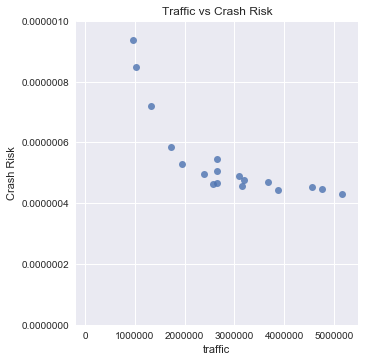

In [49]:
hourly_traffic_crashes = pd.concat([a,b], axis = 1)

hourly_traffic_crashes['normalized'] = hourly_traffic_crashes.datetime/(hourly_traffic_crashes.traffic * 4728)
sns.lmplot('traffic','normalized', data = hourly_traffic_crashes, fit_reg = False)
plt.title('Traffic vs Crash Risk')
plt.ylabel('Crash Risk')
plt.ylim([0, .000001])

## Constructing the Metric

Throughout the dataset cleaning and normalization processes two metrics have been presented for assessing the relative danger of roads, crash frequency and crash risk. Crash frequency is the simplest metric and is obtained by summing the total number of crashes that have occurred over the period during which the crash dataset was recorded(2004-2016). Crash frequency was shown to be highly affected by traffic and thus crash risk was proposed as a modification to mitigate the effects of traffic. Crash risk is found by dividing each crash by the corresponding total hourly traffic at the closest sensor to the crash. Plotting crash risk over each hour in the day revealed no positive correlation between high traffic and increased risk.

Before incorporating severity attributes to create the final metric for road danger the limitations of the crash frequency and crash risk metrics are visualized and discussed.

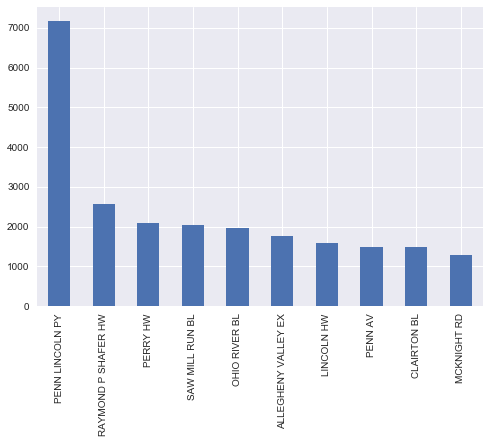

In [51]:
crash_location.STREET_NAME.value_counts().head(10).plot(kind = 'bar')

The highest crash frequency roads in the Pittsburgh area appear to all be highways. This is unsurprising given the relationship between traffic and crash frequency previously demonstrated. A metric based off crash frequency alone would frequently mistakenly assume highways and other thoroughfares to be more dangerous, when the frequency is primarily a result of the high traffic.

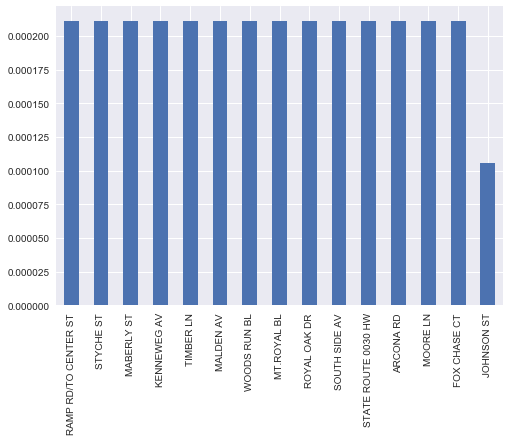

In [54]:
street_traffic = crash_location.groupby('STREET_NAME').sum().traffic
street_crashf = crash_location.STREET_NAME.value_counts().sort_index()
(street_crashf/(street_traffic * 4728)).sort_values(ascending = False).head(15).plot(kind = 'bar')

The top 14 "riskiest" roads have a uniform risk factor of .0002, or 1 crash/500 vehicles of traffic. Looking at the individual roads (in Table XXXX) reveals the reason for the consistency in risk factor.  These roads are ranked as riskiest because there is a single crash on the road and single vehicle average hourly traffic because these crashes occured at night and are in residential areas. In order to get a more useful road ranking using crash risk, the considered roads are restricted to those that have a minimum traffic of 50 cars during at least one crash and more than one crash total on the road. The minimum traffic requirement of 50 cars is chosen to eliminate residential areas and other low traffic areas where it is not possible to make conclusions about safety due to low sample size.

In [53]:
crash_location[(crash_location.STREET_NAME == 'MALDEN AV') | (crash_location.STREET_NAME == 'FOX CHASE CT') |
              (crash_location.STREET_NAME == 'SOUTH SIDE AV')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,traffic,sensor_distance
93122,40.3241,-80.120201,FOX CHASE CT,2013-04-03 17:27:00,"(835516.97071, -4797282.28676, 4105487.9388)",1.0,806.824070
134418,40.4695,-79.999300,SOUTH SIDE AV,2016-08-04 03:02:00,"(843820.858169, -4785204.02657, 4117783.92993)",1.0,525.218297
137440,40.4746,-80.033200,MALDEN AV,2016-08-01 02:30:00,"(840925.844082, -4785340.40993, 4118214.74465)",1.0,173.727799


In [55]:
# In order to determine which roads to consider set new column for max traffic for any road, this must be greater than 50
maxt_di = crash_location.groupby(crash_location.STREET_NAME).max().traffic
maxt_di.to_dict()
crash_location['max_traffic'] = crash_location.STREET_NAME.map(maxt_di)
crash_location.tail()

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,traffic,sensor_distance,max_traffic
138947,40.4541,-79.8908,KELLY ST,2016-10-07 01:02:00,"(853075.781582, -4784690.02494, 4116482.84218)",37.0,681.753346,957.000000
138948,40.4578,-79.7397,OLD FRANKSTOWN RD,2016-12-07 11:59:00,"(865643.46358, -4782161.33507, 4116795.46809)",311.0,597.310206,880.000000
138949,40.6674,-79.9790,VALENCIA RD,2016-12-06 05:14:00,"(843029.244793, -4770830.63491, 4134477.47916)",75.0,10.371036,331.000000
138950,40.4430,-79.8390,PENN LINCOLN PY,2016-12-07 01:17:00,"(857542.248496, -4784703.93343, 4115544.86237)",283.0,117.253831,996.000000
138951,40.4435,-80.0068,TENTH ST BY,2016-11-03 21:26:00,"(843519.558023, -4787159.39219, 4115587.117)",163.0,27.906064,636.166667


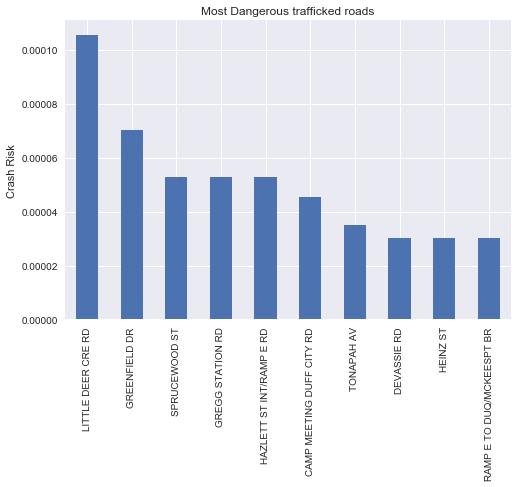

In [56]:
min_traffic = crash_location[(crash_location.max_traffic >= 50) & (crash_location.STREET_NAME.duplicated() == True)]
# duplicated() method returns boolean series indicating which streets are associated with multiple crashes
street_traffic = min_traffic.groupby('STREET_NAME').sum().traffic
street_crashf = min_traffic.STREET_NAME.value_counts().sort_index()
(street_crashf/(street_traffic * 4728)).sort_values(ascending = False).head(10).plot(kind = 'bar')
plt.title('Most Dangerous trafficked roads')
plt.ylabel('Crash Risk')

After restricting the considered roads, it is clear that Little Deer Cre[ek] road is the most risky road with 1 crash/1000 vehicles. Looking more closely at Little Deer Cre[ek] road (in table XXXX) reveals the crashes contributing to this risk factor.

In [57]:
crash_location[(crash_location.STREET_NAME == 'LITTLE DEER CRE RD')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,traffic,sensor_distance,max_traffic
18604,40.583199,-79.826302,LITTLE DEER CRE RD,2006-06-06 22:30:00,"(856816.282801, -4774559.28357, 4127380.75979)",117.0,379.931888,117.0
21930,40.596600,-79.829597,LITTLE DEER CRE RD,2006-11-05 03:45:00,"(856370.660308, -4773655.53956, 4128510.82539)",2.0,931.862354,117.0


The high crash risk factor is due to the crash at 3:45am where the low hourly traffic contributes significantly to the crash risk factor. Crash risk is calculated by crashes/total hourly traffic, for Little Deek Creek road the crash at 3:45am makes the crash risk factor 1/(4728 x 2) = .000106 while the crash at 10:30pm (22:30) adds a crash risk factor of 1/(4728 x 117) = .00000181. This demonstrates that crash risk is highly dependent on hourly traffic, a higher hourly traffic at 10:30pm resulted in a crash that did not affect the total crash risk (because of rounding). The risk factor does a good job when there is a consistent amount of traffic but crashes at low traffic times have disproportionately high influence. This can be rectified by modifying the contribution of a crash to the risk factor but the risk factor has other issues. The true danger of a road is not only a function of the frequency of its crashes, but also the severity.

The performance of the crash risk metric can also be evaluated on the roads ranked least risky, visualized below in figure XXXXX.

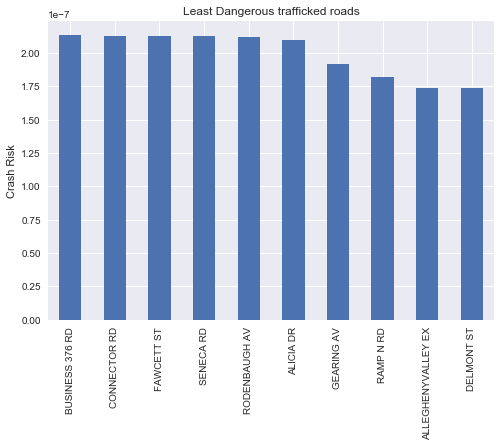

In [70]:
(street_crashf/(street_traffic * 4728)).sort_values(ascending = False).tail(10).plot(kind = 'bar')
plt.title('Least Dangerous trafficked roads')
plt.ylabel('Crash Risk')

The least dangerous roads all have high traffic which reduces the risk score. Many of these least dangerous roads are short road segments that are near heavily trafficked areas (Connector Road, Fawcett Street, Seneca Road, Alicia Drive, Gearing Avenue, Delmont Street).

The remaining streets appear to achieve the low risk score on the basis of their higher traffic due to being a thoroughfare.

In [59]:
crash_location[(crash_location.STREET_NAME == 'DELMONT ST')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,traffic,sensor_distance,max_traffic
71192,40.420898,-80.004898,DELMONT ST,2011-05-05 15:40:00,"(843960.975188, -4788734.37367, 4113676.76534)",203.5,475.906836,1218.0
72927,40.416698,-80.003899,DELMONT ST,2011-07-04 16:40:00,"(844096.996576, -4789017.44559, 4113321.70051)",1218.0,506.319558,1218.0


In [65]:
crash_severity = crash.loc[:,('FATAL', 'FATAL_COUNT', 'FATAL_OR_MAJ_INJ', 'INJURY', 'INJURY_COUNT', 'MAJ_INJ_COUNT', 'MAJOR_INJURY', 'MAX_SEVERITY_LEVEL', 'VEHICLE_COUNT','DEC_LAT','DEC_LONG')]
# Merge severity information with crash location and traffic information
crash_sev_loc = crash_severity.merge(crash_location)
# Drop duplicates from merged dataframe
crash_sev_loc.drop_duplicates(subset = ['DEC_LAT', 'DEC_LONG', 'datetime'], inplace = True)

Severity of a crash captures the injuries, and fatalities of a crash. The issue with only using Injury Count and Fatality Count to construct the severity metric is they are equally weighted (a fatality does not count as an injury in this dataset). The last term, Fatality or Major Injury + 1, is a 1 or 2 and solves the issue of underweighting serious crashes by exponentiating the severity of such crashes.

One must be added to each term because the severity will be multiplied by each crash, and a severity of zero would effectively negate the existence of the crash in the calculation of danger.

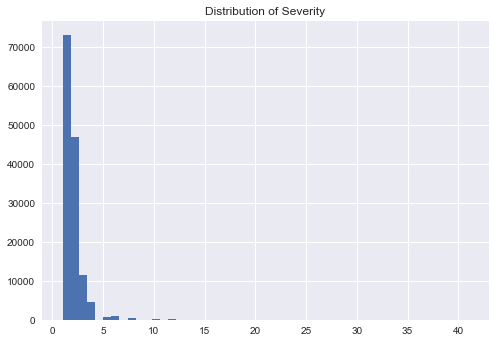

In [72]:
y = (crash_sev_loc.INJURY_COUNT + 1) * (crash_sev_loc.FATAL_COUNT + 1) * (crash_sev_loc.FATAL_OR_MAJ_INJ + 1)
crash_sev_loc['severity'] = y
y.hist(bins = 50)
plt.title('Distribution of Severity')

There are some limitations of this severity metric. Primarily, it is not easily interpretable like the crash risk metric. The other limitation is the severity metric does not distinguish between crashes of different injury levels, minor and moderate injury will result in same risk score.

Combining the severity metric with crash risk is straightforward. Crash danger on the road network is defined as the sum of crash risk * severity for all crashes on a road segment.

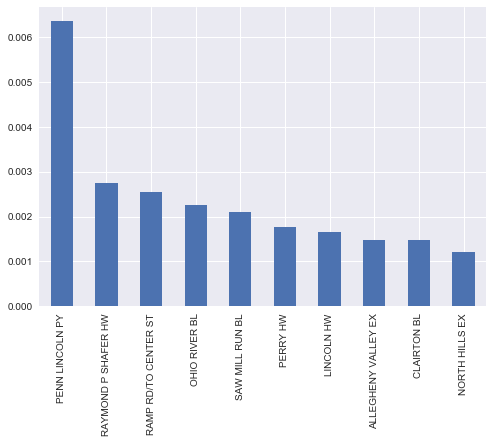

In [68]:
major_roads = crash_sev_loc[(crash_sev_loc.max_traffic >= 50) & (crash_sev_loc.STREET_NAME.duplicated() == True)]

major_traffic = crash_sev_loc.groupby('STREET_NAME').sum().traffic
major_crashf = crash_sev_loc.STREET_NAME.value_counts().sort_index()
major_sev = crash_sev_loc.groupby('STREET_NAME').sum().severity

((major_crashf * major_sev) / (major_traffic * 4728)).sort_values(ascending = False).head(10).plot(kind = 'bar')

Using the crash danger metric, the rankings shift to highways and large thoroughfares. Highways are associated with high speed limits which could be associated with higher severity crashes. The significance of conditions like roadway type, and speed limit must be analyzed statsitically to determine if the observed difference is statistically signficant.

In [104]:
import folium
from folium import plugins

In [105]:
sevcoordinates = crash_sev_loc.loc[:,('DEC_LAT', 'DEC_LONG', 'severity')].values
coordinates = crash_sev_loc.loc[:,('DEC_LAT', 'DEC_LONG')].values

In [106]:
meanlat = coordinates[:,0].mean()
meanlong = coordinates[:,1].mean()
max_amount = crash_sev_loc.severity.max()

In [109]:
s = sevcoordinates[np.random.choice(sevcoordinates.shape[0], 10000, replace=False)]

In [111]:
c = coordinates[np.random.choice(coordinates.shape[0], 10000, replace=False)]

In [110]:
m = folium.Map(location = [meanlat, meanlong], zoom_start = 9, control_scale = True)
m.add_child(plugins.HeatMap(s,
                            min_opacity = 0.3,
                            max_val = max_amount, radius =20))

In [115]:
m2 = folium.Map(location = [meanlat, meanlong], zoom_start = 9, control_scale = True)
m.add_child(plugins.HeatMap(c,
                            min_opacity = 0.3,
                            max_val = max_amount,
                            radius =20))

## Statistical Analysis

In [120]:
# Merge and drop duplicates
crash_sev_loc['danger'] = crash_sev_loc.severity/(crash_sev_loc.traffic * 4728)
crash_conditions = crash.loc[:, ('WEATHER', 'ILLUMINATION', 'INTERSECT_TYPE', 'LOCATION_TYPE', 'RELATION_TO_ROAD', 'ROAD_CONDITION', 'SPEED_LIMIT', 'TCD_FUNC_CD', 'TCD_TYPE', 'DEC_LAT', 'DEC_LONG')]
crash_sev_loc_cond = crash_conditions.merge(crash_sev_loc, on=['DEC_LAT','DEC_LONG'])
crash_sev_loc_cond.drop_duplicates(subset = ['datetime','DEC_LAT','DEC_LONG'], inplace = True)

In [121]:
weather_di = {1:'No adverse conditions',
              2: 'Rain',
              3: 'Sleet (hail)',
              4: 'Snow',
              5: 'Fog',
              6: 'Rain and fog',
              7: 'Sleet and fog',
              8: 'Other',
              9: np.NaN}
illumination_di = {1: 'Daylight',
                   2: 'Dark - no street lights',
                   3: 'Dark - street lights',
                   4: 'Dusk',
                   5: 'Dawn',
                   6: 'Dark - unknown roadway lighting',
                   8: 'Other',
                   9: np.NaN}
intersect_di = {0: 'Mid-block',
                1: 'Four way intersection',
                2: 'T intersection',
                3: 'Y intersection',
                4: 'Traffic circle/Round about',
                5: 'Multi-leg intersection',
                6: 'On ramp',
                7: 'Off ramp',
                8: 'Crossover',
                9: 'Railroad crossing',
                10: 'Other',
                99: np.NaN}
location_di = {0: 'Not applicable',
               1: 'Underpass',
               2: 'Ramp',
               3: 'Bridge',
               4: 'Tunnel',
               5: 'Toll Booth',
               6: 'Cross over related',
               7: 'Driveway or Parking Lot',
               8: 'Ramp and bridge',
               9: np.NaN}
relation_di = {1: 'On roadway',
               2: 'Shoulder',
               3: 'Median',
               4: 'Roadside',
               5: 'Outside trafficway',
               6: 'In parking lane',
               7: 'Gore',
               9: np.NaN}
# Gore is intersection of ramp and highway
road_cond = {0: 'Dry',
             1: 'Wet',
             2: 'Sand/mud/dirt/oil/gravel',
             3: 'Snow covered',
             4: 'Slush',
             5: 'Ice', 
             6: 'Ice Patches',
             7: 'Water - standing/moving',
             8: 'Other',
             9: np.NaN}
tcdtype_di = {0: np.NaN,
              1: 'Flashing traffic signal',
              2: 'Traffic signal',
              3: 'Stop sign',
              4: 'Yield sign',
              5: 'Active RR crossing controls',
              6: 'Passive RR crossing controls',
              7: 'Police officer or flagman',
              8: 'Other type TCD'}

In [122]:
crash_sev_loc_cond['WEATHER_DES'] = crash_sev_loc_cond.WEATHER.map(weather_di)
crash_sev_loc_cond['ILLUMINATION_DES'] = crash_sev_loc_cond.ILLUMINATION.map(illumination_di)
crash_sev_loc_cond['INTERSECT_DES'] = crash_sev_loc_cond.INTERSECT_TYPE.map(intersect_di)
crash_sev_loc_cond['LOCATION_DES'] = crash_sev_loc_cond.LOCATION_TYPE.map(location_di)
crash_sev_loc_cond['ROAD_RELATION_DES'] = crash_sev_loc_cond.RELATION_TO_ROAD.map(relation_di)
crash_sev_loc_cond['ROAD_CONDITION_DES'] = crash_sev_loc_cond.ROAD_CONDITION.map(road_cond)
crash_sev_loc_cond['TCD_DES'] = crash_sev_loc_cond.TCD_TYPE.map(tcdtype_di)
crash_sev_loc_cond.head()

,WEATHER,ILLUMINATION,INTERSECT_TYPE,LOCATION_TYPE,RELATION_TO_ROAD,ROAD_CONDITION,SPEED_LIMIT,TCD_FUNC_CD,TCD_TYPE,DEC_LAT,...,max_traffic,severity,danger,WEATHER_DES,ILLUMINATION_DES,INTERSECT_DES,LOCATION_DES,ROAD_RELATION_DES,ROAD_CONDITION_DES,TCD_DES
0,1.0,2.0,0.0,0.0,2.0,0.0,35.0,0.0,0.0,40.3234,...,816.0,1.0,0.000008,No adverse conditions,Dark - no street lights,Mid-block,Not applicable,Shoulder,Dry,NaN
1,1.0,1.0,0.0,0.0,5.0,6.0,35.0,0.0,0.0,40.3182,...,960.0,2.0,0.000009,No adverse conditions,Daylight,Mid-block,Not applicable,Outside trafficway,Ice Patches,NaN
2,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,40.4886,...,21.0,2.0,0.000022,No adverse conditions,Dark - no street lights,Y intersection,Not applicable,Outside trafficway,Dry,Stop sign
3,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,40.4886,...,1153.0,2.0,0.000033,No adverse conditions,Dark - no street lights,Y intersection,Not applicable,Outside trafficway,Dry,Stop sign
4,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,40.4886,...,21.0,2.0,0.000024,No adverse conditions,Dark - no street lights,Y intersection,Not applicable,Outside trafficway,Dry,Stop sign


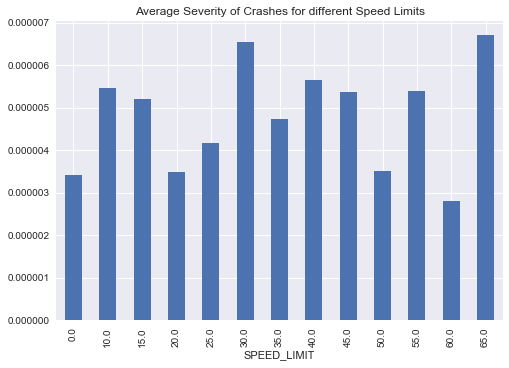

In [123]:
crash_sev_loc_cond.groupby('SPEED_LIMIT').mean().danger.plot(kind = 'bar')
plt.title('Average Severity of Crashes for different Speed Limits')

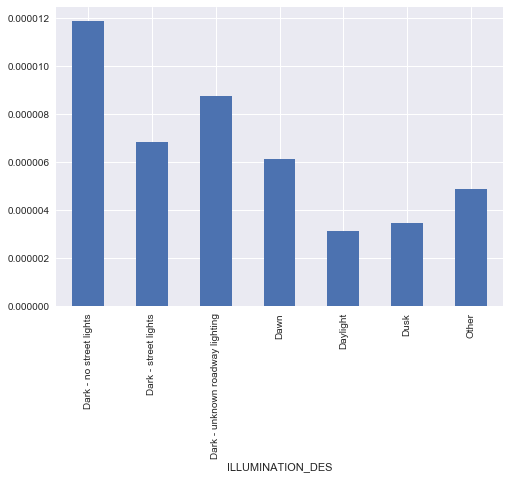

In [124]:
crash_sev_loc_cond.groupby('ILLUMINATION_DES').mean().danger.plot(kind = 'bar')

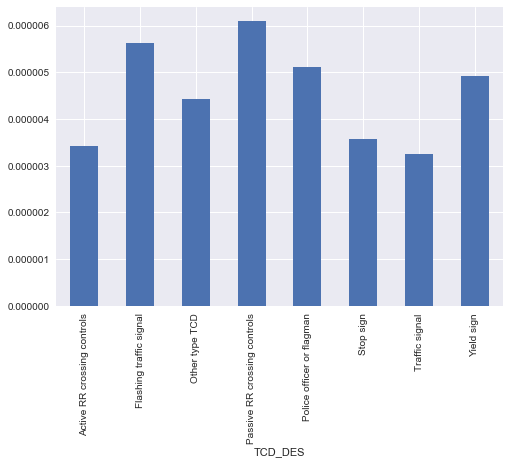

In [125]:
crash_sev_loc_cond.groupby('TCD_DES').mean().danger.plot(kind = 'bar')

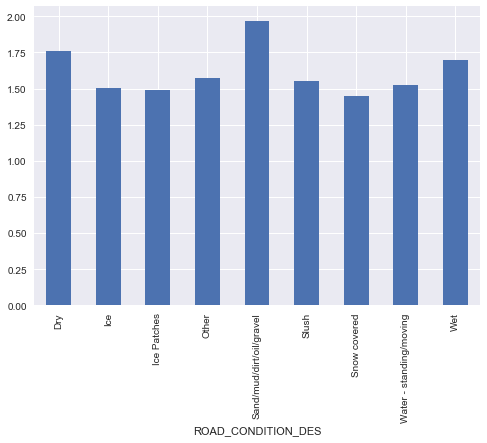

In [126]:
crash_sev_loc_cond.groupby('ROAD_CONDITION_DES').mean().severity.plot(kind = 'bar')

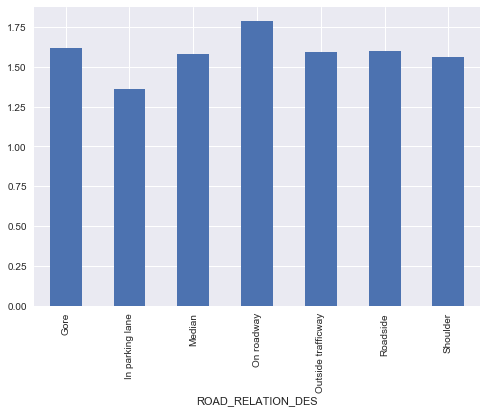

In [127]:
crash_sev_loc_cond.groupby('ROAD_RELATION_DES').mean().severity.plot(kind = 'bar')

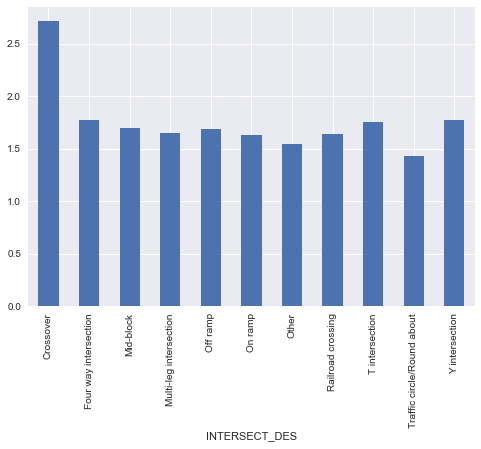

In [128]:
crash_sev_loc_cond.groupby('INTERSECT_DES').mean().severity.plot(kind = 'bar')

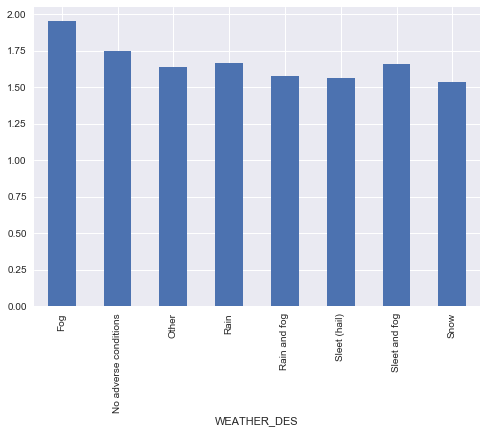

In [129]:
crash_sev_loc_cond.groupby('WEATHER_DES').mean().severity.plot(kind = 'bar')

In [130]:
danger_net = crash_sev_loc_cond.groupby('STREET_NAME').mean().danger

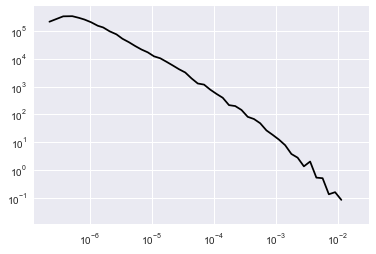

In [132]:
data = crash_sev_loc_cond.groupby('STREET_NAME').sum().danger
pl.plot_pdf(data, color = 'k')

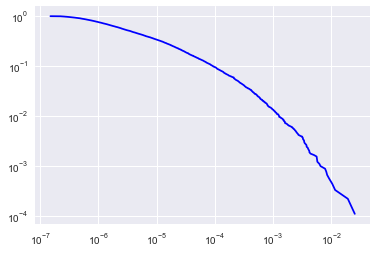

In [133]:
pl.plot_ccdf(data, color = 'b')

In [135]:
fit = pl.Fit(data)
fit.distribution_compare('power_law', 'lognormal', normalized_ratio = True)

Calculating best minimal value for power law fit
c:\users\ari\anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-1.2442590888531779, 0.21340422282383154)

In [136]:
stats.kstest(data, 'lognorm', stats.lognorm.fit(data))

KstestResult(statistic=0.057530425464127566, pvalue=2.8418001933933733e-26)

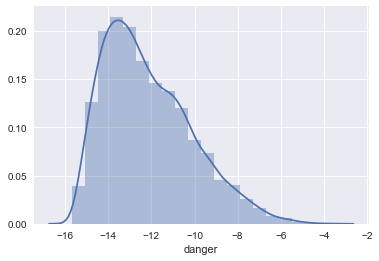

In [137]:
sns.distplot(np.log(crash_sev_loc_cond.groupby('STREET_NAME').sum().danger), bins = 20)

In [138]:
darkness = crash_sev_loc_cond[crash_sev_loc_cond['ILLUMINATION_DES'] == 'Dark - no street lights'].danger
daylight = crash_sev_loc_cond[crash_sev_loc_cond['ILLUMINATION_DES'] == 'Daylight'].danger
darkness.shape, daylight.shape

((9065,), (86193,))

In [139]:
stats.mannwhitneyu(darkness, daylight, alternative = 'greater')

MannwhitneyuResult(statistic=511246552.0, pvalue=0.0)

## Applications to Routing

# Results

# Future Work